# Demo 2: recreating the EI-1/f model
We can quickly reproduce the EI-1/f model (Gao et al. 2017) using `neurodsp` and `fooof`.

Again, need to make the imports if on Colab.

In [3]:
# !pip install fooof neurodsp

In [4]:
ON_COLAB = False
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import neurodsp as ndsp
from neurodsp import sim
import fooof


cur_dir = 'https://raw.githubusercontent.com/rdgao/specparam-sbi/main/demo_notebooks/' if ON_COLAB else './'
plt.style.use(cur_dir + 'matplotlibrc_notebook.mplstyle')

In [5]:
# Settings for simulation time.
n_seconds = 102
fs = 1000
t_ker=1.

V_rest = -65
V_rev_E = 0
V_rev_I = -80

# Exc parameters
n_neurons_E = 8000
firing_rate_E = 2
tau_r_E=0.0001
tau_d_E=0.002


# Inh parameters
n_neurons_I = 2000
firing_rate_I = 5
tau_r_I=0.0005
tau_d_I=0.01

ie_ratio = 4

# simulate the time series and clean up a bit
t = np.arange(0,n_seconds, 1/fs)
epsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_E, firing_rate_E, tau_r_E, tau_d_E, t_ker) * (V_rest-V_rev_E)
ipsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_I, firing_rate_I, tau_r_I, tau_d_I, t_ker) * (V_rest-V_rev_I)*ie_ratio

# add components to make LFP
lfp = epsc + ipsc

# compute PSDs
freqs, psd_E = signal.welch(epsc, fs=fs, nperseg=fs*2, noverlap=fs, window='hamming')
freqs, psd_I = signal.welch(ipsc, fs=fs, nperseg=fs*2, noverlap=fs, window='hamming')
freqs, psd_lfp = signal.welch(lfp, fs=fs, nperseg=fs*2, noverlap=fs, window='hamming')

Text(0.5, 0, 'frequency (Hz)')

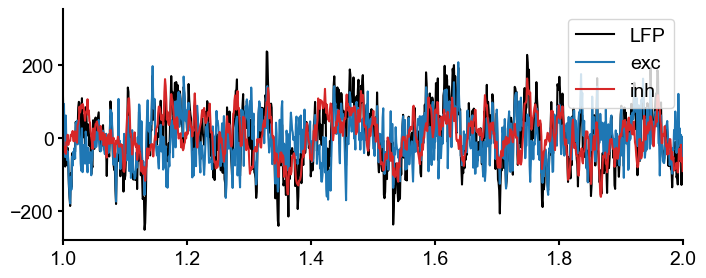

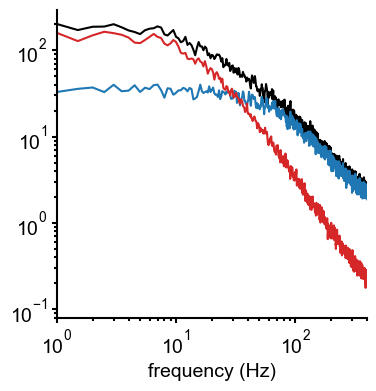

In [6]:
plot_len = 2000
plt.figure(figsize=(8,3))
plt.plot(t[:plot_len],lfp[:plot_len],'C0', label='LFP')
plt.plot(t[:plot_len],epsc[:plot_len],'C1', label='exc')
plt.plot(t[:plot_len],ipsc[:plot_len],'C4', label='inh')
plt.xlim([1,2]);
plt.legend(frameon=True);

plt.figure()
plt.loglog(freqs, psd_lfp, label= 'LFP')
plt.loglog(freqs, psd_E, 'C1', label= 'exc')
plt.loglog(freqs, psd_I, 'C4', label= 'inh')
plt.xlim([1,400]); plt.xlabel('frequency (Hz)')

### Put the code into functions.

In [7]:
def simulate_ei(ie_ratio):
    t = np.arange(0,n_seconds, 1/fs)
    epsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_E, firing_rate_E, tau_r_E, tau_d_E, t_ker) * (V_rest-V_rev_E)
    ipsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_I, firing_rate_I, tau_r_I, tau_d_I, t_ker) * (V_rest-V_rev_I)*ie_ratio
    # add components to make LFP
    lfp = epsc + ipsc
    return t, lfp, epsc, ipsc
    

def compute_all_psds(fs, lfp, epsc, ipsc, nperseg_ratio=2, noverlap_ratio=0.5):
    # compute PSDs
    nperseg = int(nperseg_ratio*fs)
    noverlap = int(nperseg_ratio*noverlap_ratio*fs)
    freqs, psd_E = signal.welch(epsc, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
    freqs, psd_I = signal.welch(ipsc, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
    freqs, psd_lfp = signal.welch(lfp, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
    return freqs, psd_lfp, psd_E, psd_I

In [8]:
t, lfp, epsc, ipsc = simulate_ei(ie_ratio)
freqs, psd_lfp, psd_E, psd_I = compute_all_psds(fs, lfp, epsc, ipsc, nperseg_ratio=2, noverlap_ratio=0.5)

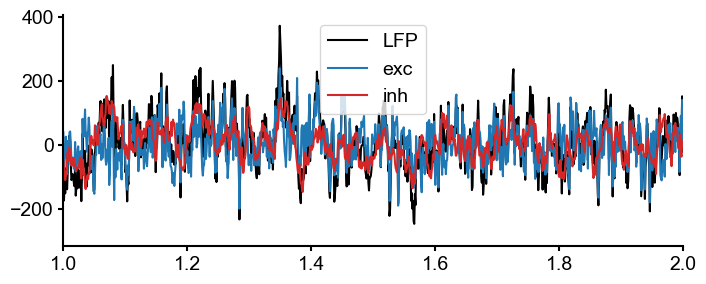

In [9]:
plot_len = 2000
plt.figure(figsize=(8,3))
plt.plot(t[:plot_len],lfp[:plot_len],'C0', label='LFP')
plt.plot(t[:plot_len],epsc[:plot_len],'C1', label='exc')
plt.plot(t[:plot_len],ipsc[:plot_len],'C4', label='inh')
plt.xlim([1,2]);
plt.legend(frameon=True);


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

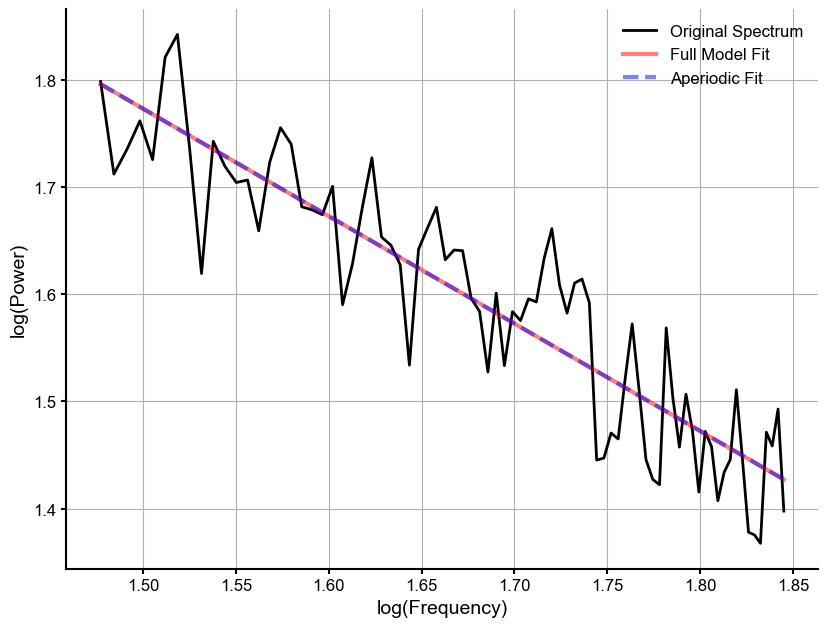

In [10]:
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=.5, aperiodic_mode='fixed')
fg.fit(freqs, psd_lfp, freq_range=[30,70])
fg.report(plt_log=True)

### Now we can run a little experiment by changing only E:I ratio and measuring exponent.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



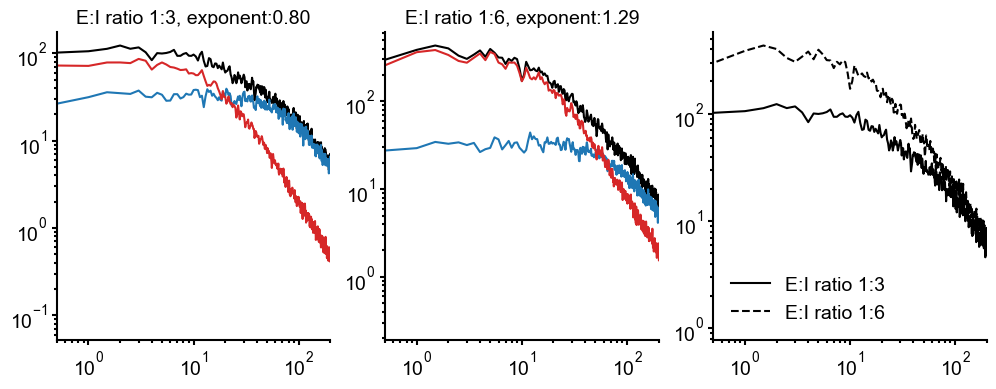

In [11]:
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=.5, aperiodic_mode='fixed')
plt.figure(figsize=(12,4))
for i_, ie_ratio in enumerate([3,6]):
    t, lfp, epsc, ipsc = simulate_ei(ie_ratio)
    freqs, psd_lfp, psd_E, psd_I = compute_all_psds(fs, lfp, epsc, ipsc, nperseg_ratio=2, noverlap_ratio=0.5)
    plt.subplot(1,3,i_+1)
    plt.loglog(freqs, psd_lfp, 'C0', label='LFP')
    plt.loglog(freqs, psd_E, 'C1', label='exc')
    plt.loglog(freqs, psd_I, 'C4', label='inh')
    plt.xlim([0.5,200]);
    
    
    fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=.5, aperiodic_mode='fixed')
    fg.fit(freqs, psd_lfp, freq_range=[30,70])
    plt.title(f'E:I ratio 1:{ie_ratio}, exponent:{fg.aperiodic_params_[1]:.2f}')
    
    plt.subplot(1,3,3)
    plt.loglog(freqs, psd_lfp, 'k--' if i_ else 'k-', label=f'E:I ratio 1:{ie_ratio}')
    plt.xlim([0.5,200]);

plt.legend();

### Challenge
Reproduce the same change in exponent above, but only by changing one of the other model parameters other than E:I ratio.